In [0]:
from moviepy.video.io.ffmpeg_tools import ffmpeg_extract_subclip
import os
import cv2 
from PIL import Image
from tqdm.notebook import tqdm
import numpy as np
from numpy import moveaxis
from IPython.display import clear_output
import matplotlib.pyplot as plt
# import pandas as pd
import shutil
plt.rcParams["figure.figsize"] = (10,10)

ROOT = "/content/drive/My Drive/"

In [0]:
!tar -czf work_data.tar.gz -C /content/drive/"My Drive"/work_data .
!mkdir work_data
!tar -xvf  /content/work_data.tar.gz -C /content/work_data .

In [0]:
def trim_video(source_path, start_time, end_time, target_path):
    ffmpeg_extract_subclip(source_path, start_time, end_time, targetname=target_path)

In [12]:
source_path = "work_data/video/c_elegans_movement.mp4"
target_path = "work_data/trimmed/first_five_seconds.mp4"

trim_video(
    source_path = source_path, 
    start_time =20, 
    end_time =  50, 
    target_path = target_path)


[MoviePy] Running:
>>> /root/.imageio/ffmpeg/ffmpeg-linux64-v3.3.1 -y -i work_data/video/c_elegans_movement.mp4 -ss 20.00 -t 30.00 -vcodec copy -acodec copy work_data/trimmed/first_five_seconds.mp4
... command successful.


In [0]:
def video_to_frames(video_path, new_folder_path):
    
    frames_paths = []
    
    try:
        os.mkdir(new_folder_path)
    except:
        shutil.rmtree(new_folder_path)
        os.mkdir(new_folder_path)

        
    vidObj = cv2.VideoCapture(video_path)   
    success = 1
    count = 0
    while success: 
        success, image = vidObj.read() 
        fmt_name = new_folder_path + "/" + str(count)+ ".jpg"
        try:
            cv2.imwrite(fmt_name, image)
            frames_paths.append(fmt_name)
            count += 1
        except:
            pass 
    print ("saved ", count-1, " frames at ", new_folder_path)
    
    return frames_paths


In [14]:
frames_folder = "work_data/trimmed/frames"
frames_paths = video_to_frames(
                                video_path = target_path,
                                new_folder_path = frames_folder
                               )

saved  749  frames at  work_data/trimmed/frames


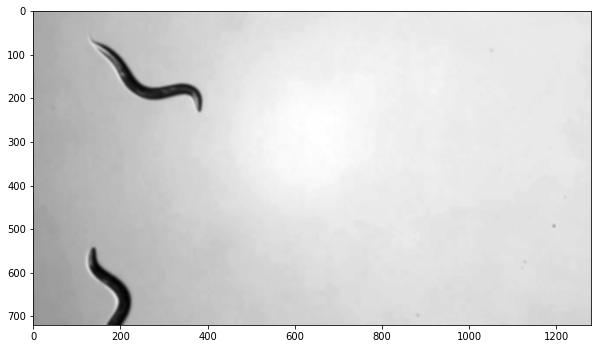

(720, 1280)


In [9]:
sample_image = cv2.imread(frames_folder+ "/" + "1.jpg", 0)
sample_image = cv2.blur(sample_image,(7,7)) 
plt.imshow(sample_image, cmap = "gray")
plt.show()
print(sample_image.shape)

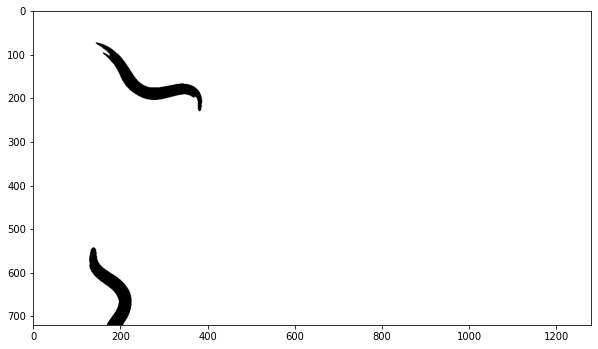

In [10]:
ret,thresh1 = cv2.threshold(sample_image,90, 255,cv2.THRESH_BINARY)
plt.imshow(thresh1, cmap = "gray")
plt.show()

In [0]:
def find_worms_return_vertices(thresh_image, minimum_size = 50, padding = 20):
    rect_vertices = []
    contours, hierarchy = cv2.findContours(thresh_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    for contour in contours:
        (x, y, w, h) = cv2.boundingRect(contour)

        if 0 in (x,y,w,h): ## skip invali stuff 
            continue
        if w < minimum_size or h < minimum_size :  # skip if too small to be a worm
            continue

        w += padding 
        h+= padding 

        

        rect_vertices.append([(x - padding , y - padding ), (x+w, y+h)])

    return rect_vertices



def threshold_image_np(raw_img, upper_gray_threshold):  ## converts all pixels above upper_gray_threshold to 255 = white 
    
    ret,thresh1 = cv2.threshold(raw_img ,upper_gray_threshold,  255, cv2.THRESH_BINARY)
    return thresh1



def read_and_shrink_image(image_path, shrink_factor = 2):
    raw_img = cv2.imread(image_path, 0) ## 0 means grayscale = 1 color channel 
    raw_img_small = cv2.resize(raw_img, (int(raw_img.shape[1]/shrink_factor), int(raw_img.shape[0]/shrink_factor)))
    return raw_img_small



def draw_circle(image, vertex, radius):
    
    with_circle = cv2.circle(
                            image,                
                            vertex, 
                            radius = radius, 
                            color = (0, 100, 255) , 
                            thickness = 2)
    return with_circle



def draw_rectangle(image, vertex1, vertex2):
    image = cv2.rectangle(image,
                    vertex1,
                    vertex2,
                    color=(0, 255, 0), thickness=3)
    return image

In [ ]:
rects_save_folder = "work_data/trimmed/rects"

try:
    os.mkdir(rects_save_folder)
except:
    shutil.rmtree(rects_save_folder)
    os.mkdir(rects_save_folder)

imcount = 0
for i in tqdm(frames_paths):
    
    
    image_path = i
    save_name = rects_save_folder + "/"+ str(imcount) + ".jpg"
    
    try:
        raw_img_small = read_and_shrink_image(image_path, shrink_factor = 4)
        raw_img_small = cv2.blur(raw_img_small,(5,5)) 
    except:
        continue
         
    thresh = threshold_image_np(raw_img_small, upper_gray_threshold = 90)
    
    vertices = find_worms_return_vertices(thresh, minimum_size = 9, padding = 11)

  
    for vertex in vertices:

        raw_img_small = draw_rectangle(raw_img_small, vertex[0], vertex[1])
        # raw_img_small = cv2.putText(raw_img_small, 'worm', ( vertex[1][0], vertex[0][1]-10), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (36,255,12), 2)
        
    raw_img_color = cv2.applyColorMap( raw_img_small , colormap = cv2.COLORMAP_JET)
        
    cv2.imwrite( save_name, raw_img_color)
    
    
    imcount += 1

In [0]:
rect_save_paths = [rects_save_folder + "/" + str(i) + ".jpg" for i in range (imcount)]

In [51]:
from PIL import Image 

images = []
for n in rect_save_paths:
    frame = Image.open(n)
    images.append(frame)

images[0].save('interpolation.gif',
               save_all=True,
               append_images=images[1:350],
               duration=1,
               loop=0)
print(len(images))

750
